In [1]:
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import pystan
%matplotlib inline

# Mixture example

The following mixture model from [C-K Hur, A. V. Nori, S. K. Rajamani, and S. Samuel, "A Provably Correct Sampler for Probabilistic Programs"](http://sf.snu.ac.kr/gil.hur/publications/fsttcs15.pdf) is highlighted as a difficult case for Stan and R2:

```
1: double x, y;
2: x ~ Gaussian(0, 1);
3: if (x > 0) then
4:    y ~ Gaussian(10, 2);
5: else
6:    y ~ Gamma(3, 3);
7: return y;
```

### Baseline

* Straight-forward to direct-sample and also show the analytic curve
* Will give an idea of what the distribution is suppose to look like

In [15]:
def mixture_sample():
    x = np.random.normal(0, 1)
    if x > 0:
        y = np.random.normal(10, 2)
    else:
        y = np.random.gamma(3, 1./3)
    return y

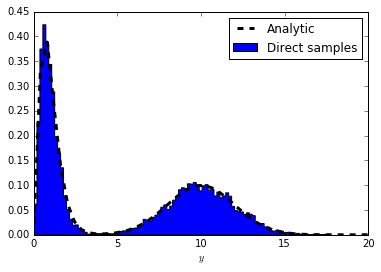

In [45]:
plt.hist(
        [mixture_sample() for _ in xrange(10000)],
        normed=True,
        bins=100,
        histtype='stepfilled',
        label='Direct samples'
)

sigma = 2.
X = np.linspace(0, 20)
Y = 0.5/np.sqrt(2*sigma**2*np.pi)*np.exp(-0.5*(X-10)**2/sigma**2) + \
    0.5*scipy.stats.gamma.pdf(X,3,scale=1./3)

plt.plot(X,Y, c='k', ls='--', lw=3, label='Analytic')
plt.legend(loc='best')
plt.xlabel('$y$');

### PyStan

* We can check to see if Stan samples the correct distribution:

In [47]:
mixture_code = """
parameters {
    real x;
    real y;
}
model {
    x ~ normal(0, 1);
    if(x > 0) {
        y ~ normal(10, 2);
    } else {
        y ~ gamma(3, 3);
    }
}
"""

In [48]:
mixture_fit = pystan.stan(model_code=mixture_code, iter=4000)

In [49]:
print mixture_fit

Inference for Stan model: anon_model_6f895cde7c27da044508de58a69e7bc8.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x       0.8    0.02   0.61   0.03   0.31   0.68   1.16   2.27 1292.0    1.0
y     10.07    0.05   1.97   6.13   8.72   10.1   11.4   13.9 1507.0    1.0
lp__  -0.99    0.03   0.99  -3.65  -1.37  -0.69  -0.29  -0.02 1275.0    1.0

Samples were drawn using NUTS(diag_e) at Thu Jun  9 19:23:12 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


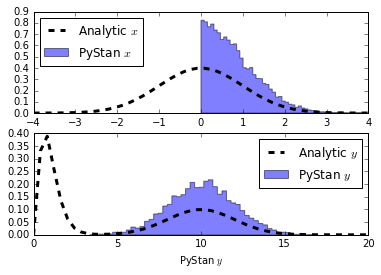

In [50]:
plt.subplot(2,1,1)
plt.hist(mixture_fit.extract()['x'], normed=True, bins=50, histtype='stepfilled', label='PyStan $x$', alpha=0.5)

X1 = np.linspace(-4,4, 50)
Y1 = 1./np.sqrt(2*np.pi)*np.exp(-0.5* X1 ** 2)
plt.plot(X1,Y1, c='k', ls='--', lw=3, label='Analytic $x$')
plt.legend(loc='best')
plt.xlabel('$x$');

plt.subplot(2,1,2)
plt.hist(mixture_fit.extract()['y'], normed=True, bins=50, histtype='stepfilled', label='PyStan $y$', alpha=0.5);

plt.plot(X,Y, c='k', ls='--', lw=3, label='Analytic $y$')
plt.legend(loc='best')
plt.xlabel('PyStan $y$');

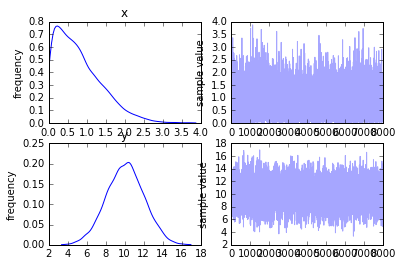

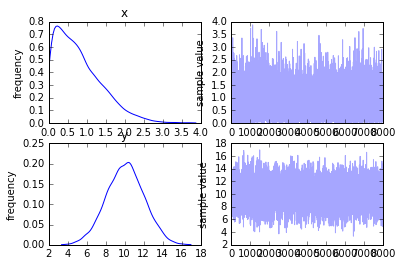

In [51]:
mixture_fit.traceplot()

### M-H sampling using only the last successful values

* The Hur paper indicates that Stan follows the approach of 
[D. Wingate, A. Stuhlmüller, and N. D. Goodman, "Lightweight implementations
of probabilistic programming languages via transformational compilation"](http://jmlr.csail.mit.edu/proceedings/papers/v15/wingate11a/wingate11a.pdf)
* If I understand this approach correctly, the sampled values for all code branches are held in a database (or dict, or map, or whatever), and updated when samples through that path are accepted. In this case, you can end up using previous values that originate from iterations well before the previous.

In [43]:
n_steps = 100000
samples = [(1,1)] #start somewhere

#this is the trace-database of values needed to calculate the M-H acceptance condition
previous_values = {
    "x": np.random.normal(0, 1),
    "y_branch_0": np.random.normal(10, 2),
    "y_branch_1": np.random.gamma(3, 1./3),
}

#probability distributions definitions
x_pdf = scipy.stats.norm(0,1)
y_branch_0_pdf = scipy.stats.norm(10,2)
y_branch_1_pdf = scipy.stats.gamma(3, scale=1./3)

for step in xrange(n_steps):
    change_log = []
    
    x_new = previous_values['x'] + np.random.normal(0,1)
    beta_x = min(1, x_pdf.pdf(x_new) / x_pdf.pdf(previous_values['x']))
    change_log.append(('x', x_new))
    
    if x_new > 0:
        branch = 'y_branch_0'
        y_new = previous_values[branch] + np.random.normal(0,1)
        beta_y = min(1, y_branch_0_pdf.pdf(y_new) / y_branch_0_pdf.pdf(previous_values[branch]))
        change_log.append((branch, y_new))
    else:
        branch = 'y_branch_1'
        y_new = previous_values[branch] + np.random.normal(0,1)
        beta_y = min(1, y_branch_1_pdf.pdf(y_new) / y_branch_1_pdf.pdf(previous_values[branch]))
        change_log.append((branch, y_new))
    
    #M-H acceptance condition
    if np.random.uniform(0,1) < beta_x*beta_y:
        samples.append((x_new, y_new))
        
        #apply the applicable changes to the trace-database
        for change in change_log:
            previous_values[change[0]] = change[1]
    else:
        samples.append(samples[-1])

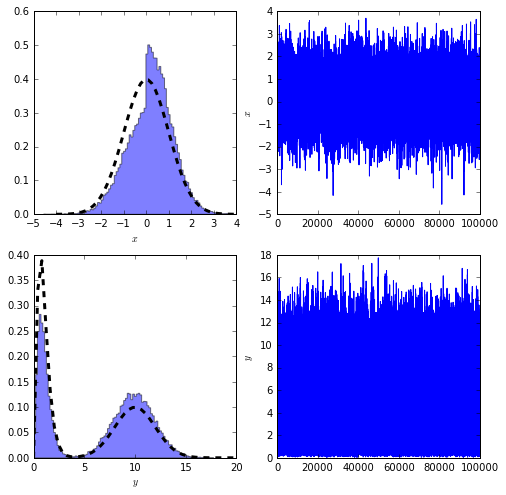

In [46]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.hist(
    [s[0] for s in samples],
    normed=True,
    bins=100,
    histtype='stepfilled',
    label='$x$',
    alpha=0.5
)

X1 = np.linspace(-4,4, 50)
Y1 = 1./np.sqrt(2*np.pi)*np.exp(-0.5*X1 ** 2)
plt.plot(X1,Y1, c='k', ls='--', lw=3, label='Analytic $x$')
plt.xlabel('$x$');

plt.subplot(2,2,2)
plt.plot([s[0] for s in samples])
plt.ylabel('$x$')

plt.subplot(2,2,3)
plt.hist(
    [s[1] for s in samples],
    normed=True,
    bins=100,
    histtype='stepfilled',
    label='$y$',
    alpha=0.5
);

plt.plot(X,Y, c='k', ls='--', lw=3, label='Analytic $y$')
plt.xlabel('$y$');

plt.subplot(2,2,4)
plt.plot([s[1] for s in samples])
plt.ylabel('$y$');

This simple implementation does a bit better, but doesn't quite provide the correct distribution.

# M-H sampling with saving distribution information

* The Hur paper describes saving information about the distribution along with the sampled value so that the correct M-H acceptance condition can be constructed regardless of which path the program executes
* Here, I've applied this process explicitly for the sample mixture distribution. The paper describes how to generalize this approach, but I kept it simple for pedagogical purposes

In [41]:
n_steps = 100000
samples2 = [(1,1)] #start somewhere

#probability distributions definitions
def dist_value(p):
    dist, value = p
    if dist == 'x':
        return scipy.stats.norm(0,1).pdf(value)
    elif dist == 'y_branch_0':
        return scipy.stats.norm(10,2).pdf(value)
    elif dist == 'y_branch_1':
        return scipy.stats.gamma(3, scale=1./3).pdf(value)

#naive initialization of the pre-lists
x_pre = ('x', np.random.normal(0, 1))
y_pre = ('y_branch_1', np.random.gamma(3, scale=1./3))

for step in xrange(n_steps):
    #populate the current-lists
    x_cur = ('x', x_pre[1] + np.random.normal(0,1))
    if x_cur[1] > 0:
        y_cur = ('y_branch_0', y_pre[1] + np.random.normal(0,1))
    else:
        y_cur = ('y_branch_1', y_pre[1] + np.random.normal(0,1))
    
    beta =  (dist_value(x_cur)/dist_value(x_pre)) \
           *(dist_value(y_cur)/dist_value(y_pre))
    
    #M-H acceptance condition
    if np.random.uniform(0,1) < min(1,beta):
        samples2.append((x_cur[1], y_cur[1]))
        x_pre = x_cur
        y_pre = y_cur
    else:
        samples2.append(samples2[-1])

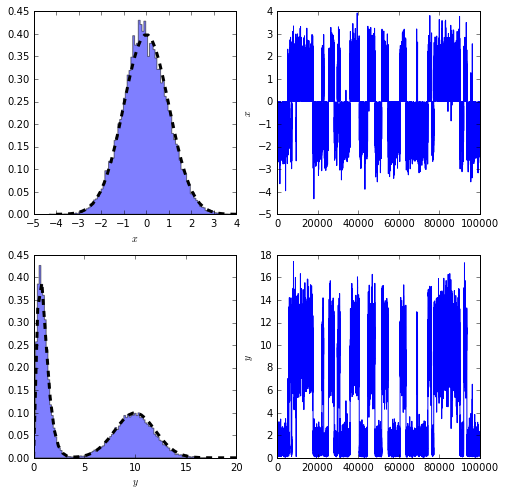

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.hist(
    [s[0] for s in samples2],
    normed=True,
    bins=100,
    histtype='stepfilled',
    label='$x$',
    alpha=0.5
)

X1 = np.linspace(-4,4, 50)
Y1 = 1./np.sqrt(2*np.pi)*np.exp(-0.5*X1 ** 2)
plt.plot(X1,Y1, c='k', ls='--', lw=3, label='Analytic $x$')
plt.xlabel('$x$');

plt.subplot(2,2,2)
plt.plot([s[0] for s in samples2])
plt.ylabel('$x$')

plt.subplot(2,2,3)
plt.hist(
    [s[1] for s in samples2],
    normed=True,
    bins=100,
    histtype='stepfilled',
    label='$y$',
    alpha=0.5
);

plt.plot(X,Y, c='k', ls='--', lw=3, label='Analytic $y$')
plt.xlabel('$y$');

plt.subplot(2,2,4)
plt.plot([s[1] for s in samples2])
plt.ylabel('$y$');

Not bad